# Summarize GPS information

<div class="alert alert-block alert-success">
<b>Up to you:</b> To launch this notebook, you have to:<br/>
1. Go to tracklib/doc/source/notebook on a console,<br/>
2. Start the notebook server from the command line: jupyter notebook,<br/>
3. You should see the notebook open in your browser. Open "Switchbacks" by clicking on the link.<br/>
</div>

<p style='padding:8px'>This functionality of tracklib reduce the full dataset of GPS traces into a regular grid of summarized features. In each cell, <i>n</i> aggregated features (such as mean and standard deviation of speeds, number of traces, most frequent bearing ...) are computed to produce a set of raster maps, which may be seen as a single image with <i>n</i> channels.</p>

<p style='padding:8px'>These process has been used in works presented in (1).</p>

<figure style='text-align:center'>
<img src="summarize3.png"  width="650" />
<figcaption><br/>Figure 1 : Workflow presented in (1) to produce raster images (5 meter-resolution grid)</figcaption>
</figure>

<div class="alert alert-block alert-info">
<b>Reference:</b><br/>(1) - Y. Méneroux and al. Convolutional Neural Network for Traffic Signal Inference based on GPS Traces. Proceedings of Spatial big data and machine learning in GIScience Workshop'18, August 28-31, 2018, Melbourne, Australia. GIScience.</div>



## Import de la librairie tracklib

Il faut importer tracklib si la librairie n'est pas dans le python path

In [1]:
# -*- coding: utf-8 -*-
import matplotlib.pyplot as plt
import os.path
import sys

#-------------------------------------------------------
# Import de tracklib
module_path = os.path.abspath(os.path.join('../../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

## Chargement du jeu de traces

The dataset comprises a set of 11862 GPS traces, located in Mitaka city (16 km2), suburbs of Tokyo (Japan).

In [2]:
from tracklib.io.TrackReader import TrackReader as reader
from tracklib.core.GPSTime import GPSTime

PATH = '/home/marie-dominique/PROJET/FINI/MITAKA/DATA/mitaka/complet'
GPSTime.setReadFormat("4Y-2M-2D 2h:2m:2s")
collection = reader.readFromCsvFiles(path=PATH, id_E=2, id_N=3, id_T=1)
print ('Number of tracks: ' + str(collection.size()))

Number of tracks: 11872


## Nettoyage des traces

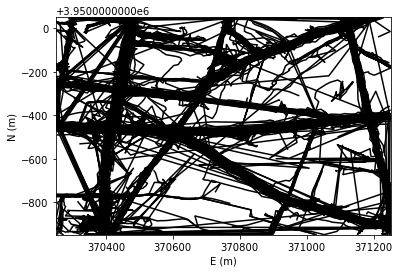

Number of tracks: 3794


In [3]:
import matplotlib.pyplot as plt

from tracklib.core.TrackCollection import TrackCollection
from tracklib.core.Track import Track

Xmin=370250
Xmax=371250
Ymin=3949050
Ymax=3950050

selections = TrackCollection()
for i in range(collection.size()):
    trace = collection.getTrack(i)
    
    t = Track()
    for j in range(trace.size()):
        o = trace.getObs(j)
        x = o.position.getX()
        y = o.position.getY()
        if x <= Xmax and x >= Xmin and y <= Ymax and y >= Ymin:
            t.addObs(o)
    
    if t.size() > 10:
        selections.addTrack(t)
        t.plot()

plt.xlim((Xmin, Xmax))
plt.ylim((Ymin, Ymax))
plt.show()

print ('Number of tracks: ' + str(selections.size()))
collection = selections

## Raster de la moyenne des vitesses et de l'orientation de la plus fréquente par cellule

Les AF seront calculées si elles n'ont pas encore été créées

Les scripts des deux AF qu'on prend existent déjà dans la librairie, sinon il aurait fallu les écrire

In [4]:
from tracklib.algo import (Analytics, Summarising) 

# On crée l'AF speed
collection.addAnalyticalFeature(Analytics.speed)

af_algos = [Analytics.speed, Analytics.orientation]
cell_operators = [Summarising.co_avg, Summarising.co_dominant]  

marge = 0
resolution = (5, 5)
raster = Summarising.summarize(collection, af_algos, cell_operators, resolution, marge)

## Conversion de la vitesse moyenne en 8-bit grayscale 

In [5]:
import tracklib.core.RasterBand as grid

# Feature values are converted on a 8-bit grayscale. To differentiate
# the value 0 from the absence of data, the minimum threshold taken by the values is 16 (e.g. the
# mean of speeds is distributed between 16 and 255).
band = raster.bands['speed#co_avg']
# band = raster.bands['orientation#co_dominant']
for i in range(band.nrow):
    for j in range(band.ncol):
        val = band.grid[i][j]
        if val == grid.NO_DATA_VALUE:
            #print (val)
            band.grid[i][j] = 0
        elif val >= 50:
            band.grid[i][j] = 40
        else:
            band.grid[i][j] = 255 - val / 50 * (255-40)


## Affichage

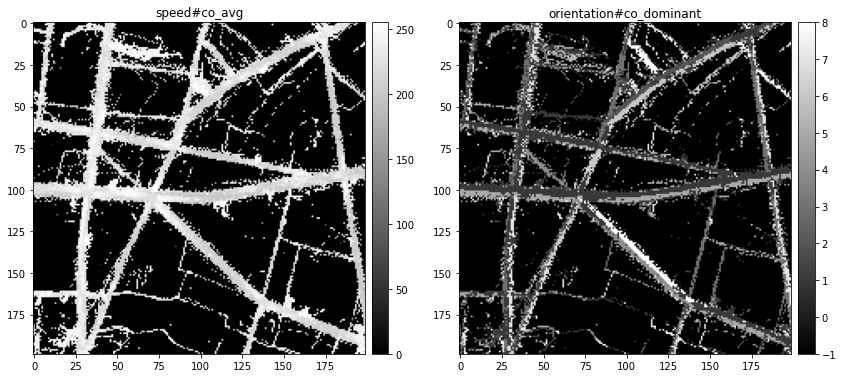

In [11]:
fig = plt.figure(figsize=(14, 7))

ax1 = fig.add_subplot(121)
raster.plot(Analytics.speed, Summarising.co_avg, 
                no_data_values = 0, axe = ax1, figure = fig)

ax2 = fig.add_subplot(122)
raster.plot(Analytics.orientation, Summarising.co_dominant, 
                no_data_values = -1, axe = ax2, figure = fig)
